In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain.llms import HuggingFacePipeline
from Tools import SDTools

# Configs

In [2]:
# LLM Config
BASE_MODEL="LLM/llama/llama-2-7b-chat-hf"
# Stable diffusion Config
url = '127.0.0.1'
port = 7860
usehttp = False
username = None # modify it if --api-auth=username:password is set on webui. 
password = None
t2i = SDTools(url, port,username, password, usehttp)

In [3]:
trigger = '<t2i>' # set the command word that you want to trigger the sd model

# Model

In [4]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, )
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL,torch_dtype=torch.float16,device_map='cuda:0')
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=4096,
    temperature=0.1,
    top_p=0.95,
    repetition_penalty=1.2
)

llm = HuggingFacePipeline(pipeline=pipe)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [5]:
input = trigger + """
Seeing plants and flowers from the ground, view from below, atmospheric dreamscape painting, dream scenery art, highly detailed visionary art, cgi style, vibrant oil painting, splash art, Cozy mystery, masterpiece 8k wallpapper, neoplasticism, Unreal Engine, dramatic lighting
Negative prompt: worst quality, low quality, extra digits,<lora:dreamwave:1>,
Steps: 43, Size: 512x512, Model: anything, Seed: 12415920, Sampler: Euler a, CFG scale: 7, Clip skip: 1
"""

# Let's chat!

## 1. Trigger with ConversationChain

In [6]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory()
chatbot = ConversationChain(llm=llm, memory=memory, verbose=False)

In [7]:
def chat(text: str):
    draw = text.startswith(trigger)
    if draw:
        response = "Start to draw a picture"
        img = t2i.txt2img(text)
        return img
    else:
        response = chatbot.invoke(text)
    return response

In [8]:
chat("who you are")

{'input': 'who you are',
 'history': '',
 'response': " I am an artificial intelligence trained on a large dataset of text from various sources including books, articles, websites, etc. My primary function is to understand and generate natural language text based on patterns learned from this data. I can converse with humans in a way that simulates human-like dialogue, but please keep in mind that I'm just an AI and do not have personal experiences or emotions like humans do. How may I assist you today? "}

loading anything-v5-PrtRE.safetensors [7f96a1a9ca]
model changed to anything-v5-PrtRE.safetensors [7f96a1a9ca]


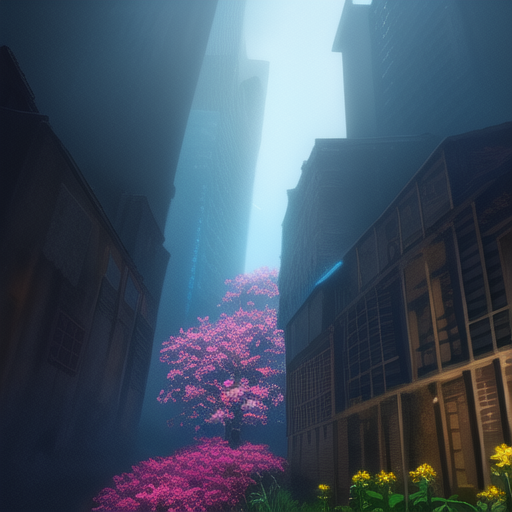

In [9]:
chat(input)

## 2. Langchain Agent

In [10]:
from langchain.chains import LLMChain
from langchain.tools import Tool
from langchain.prompts import PromptTemplate
from langchain.tools import BaseTool
from IPython.display import display
from Agent import IntentAgent
from langchain.agents import AgentExecutor

In [11]:
class GenerateImage_Tool(BaseTool):
    name:str =  "generate image"
    url:str = '127.0.0.1'
    port:int = 7860
    usehttp:bool = False
    username:str = None
    password:str = None
    trigger = '<t2i>'
    description:str= f"If the text contains the word '{trigger}', then pass all the words after '{trigger}' to this tool and do not allow any modification of the input text."
    t2i:SDTools = None
    def _run(self, prompt:str):
        self.get_t2i_tools()
        img = self.t2i.txt2img(prompt)
        ############ The following visualization code is for demonstration purposes only and may need to remove and change to save.  ############
        display(img)
        return f"Finish image generation!\nThe prompt is {prompt}"
    
    def _call_func(self, prompt:str):
        self.get_t2i_tools()
        img = self.t2i.txt2img(prompt)
        ############ The following visualization code is for demonstration purposes only and may need to remove and change to save.  ############
        display(img)
        return f"Finish image generation!\nThe prompt is {prompt}"

    def get_t2i_tools(self):
        self.t2i = SDTools(self.url, self.port, self.username, self.password, self.usehttp)

tools = [GenerateImage_Tool(url=url, port=port, usehttp=usehttp, username=username, password=password)]

In [12]:
prompt = PromptTemplate(
    input_variables = ["query"],
    template = "{query}"
)

llm_chain = LLMChain(llm = llm, prompt = prompt)

# initialize the LLM tool
llm_tool = Tool(
    name ='language model',
    func = llm_chain.run,
    description ='use this tool for general purpose queries and logic'
)
tools.append(llm_tool)

In [13]:
agent = IntentAgent(trigger=trigger, llm=llm)
agent_exec = AgentExecutor.from_agent_and_tools(agent=agent, tools=tools, verbose=True, max_iterations=1) 



> Entering new AgentExecutor chain...
loading anything-v5-PrtRE.safetensors [7f96a1a9ca]
model changed to anything-v5-PrtRE.safetensors [7f96a1a9ca]


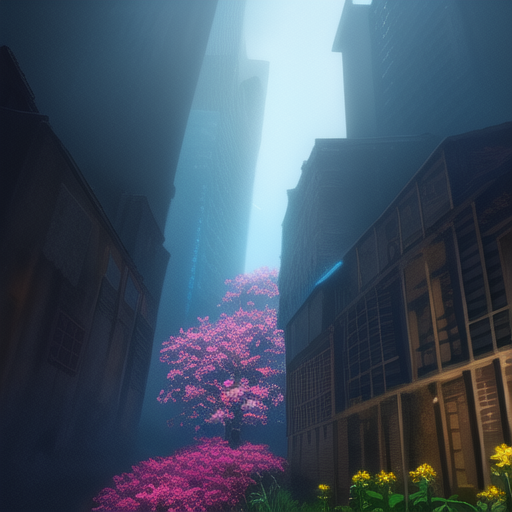

Finish image generation!
The prompt is <t2i>
Seeing plants and flowers from the ground, view from below, atmospheric dreamscape painting, dream scenery art, highly detailed visionary art, cgi style, vibrant oil painting, splash art, Cozy mystery, masterpiece 8k wallpapper, neoplasticism, Unreal Engine, dramatic lighting
Negative prompt: worst quality, low quality, extra digits,<lora:dreamwave:1>,
Steps: 43, Size: 512x512, Model: anything, Seed: 12415920, Sampler: Euler a, CFG scale: 7, Clip skip: 1


> Finished chain.


{'input': '<t2i>\nSeeing plants and flowers from the ground, view from below, atmospheric dreamscape painting, dream scenery art, highly detailed visionary art, cgi style, vibrant oil painting, splash art, Cozy mystery, masterpiece 8k wallpapper, neoplasticism, Unreal Engine, dramatic lighting\nNegative prompt: worst quality, low quality, extra digits,<lora:dreamwave:1>,\nSteps: 43, Size: 512x512, Model: anything, Seed: 12415920, Sampler: Euler a, CFG scale: 7, Clip skip: 1\n',
 'output': 'Agent stopped due to iteration limit or time limit.'}

In [14]:
agent_exec.invoke(input)

## Another example

In [15]:
input = trigger + """
1girl,cute smile,medium and silver hair,bangs,<lora:dreamwave:0.6>,
Negative prompt: longbody,lowres,bad anatomy,bad hands,missing fingers,pubic hair,extra digit,fewer digits,cropped,worst quality,low quality,
Steps: 20, Sampler: Euler a, CFG scale: 7, Seed: 3687350510, Size: 512x512, Model hash: 7f96a1a9ca, Model: anything-v5-PrtRE, Denoising strength: 0.4, Clip skip: 2, ADetailer model: face_yolov8n.pt, ADetailer confidence: 0.3, ADetailer dilate erode: 4, ADetailer mask blur: 4, ADetailer denoising strength: 0.4, ADetailer inpaint only masked: True, ADetailer inpaint padding: 32, ADetailer model 2nd: hand_yolov8n.pt, ADetailer confidence 2nd: 0.3, ADetailer dilate erode 2nd: 4, ADetailer mask blur 2nd: 4, ADetailer denoising strength 2nd: 0.4, ADetailer inpaint only masked 2nd: True, ADetailer inpaint padding 2nd: 32, ADetailer model 3rd: person_yolov8n-seg.pt, ADetailer confidence 3rd: 0.3, ADetailer dilate erode 3rd: 4, ADetailer mask blur 3rd: 4, ADetailer denoising strength 3rd: 0.4, ADetailer inpaint only masked 3rd: True, ADetailer inpaint padding 3rd: 32, ADetailer version: 23.11.1, Hires upscale: 2, Hires upscaler: Latent, Lora hashes: "dreamwave: 8810332ef869"
"""



> Entering new AgentExecutor chain...
loading anything-v5-PrtRE.safetensors [7f96a1a9ca]
model changed to anything-v5-PrtRE.safetensors [7f96a1a9ca]


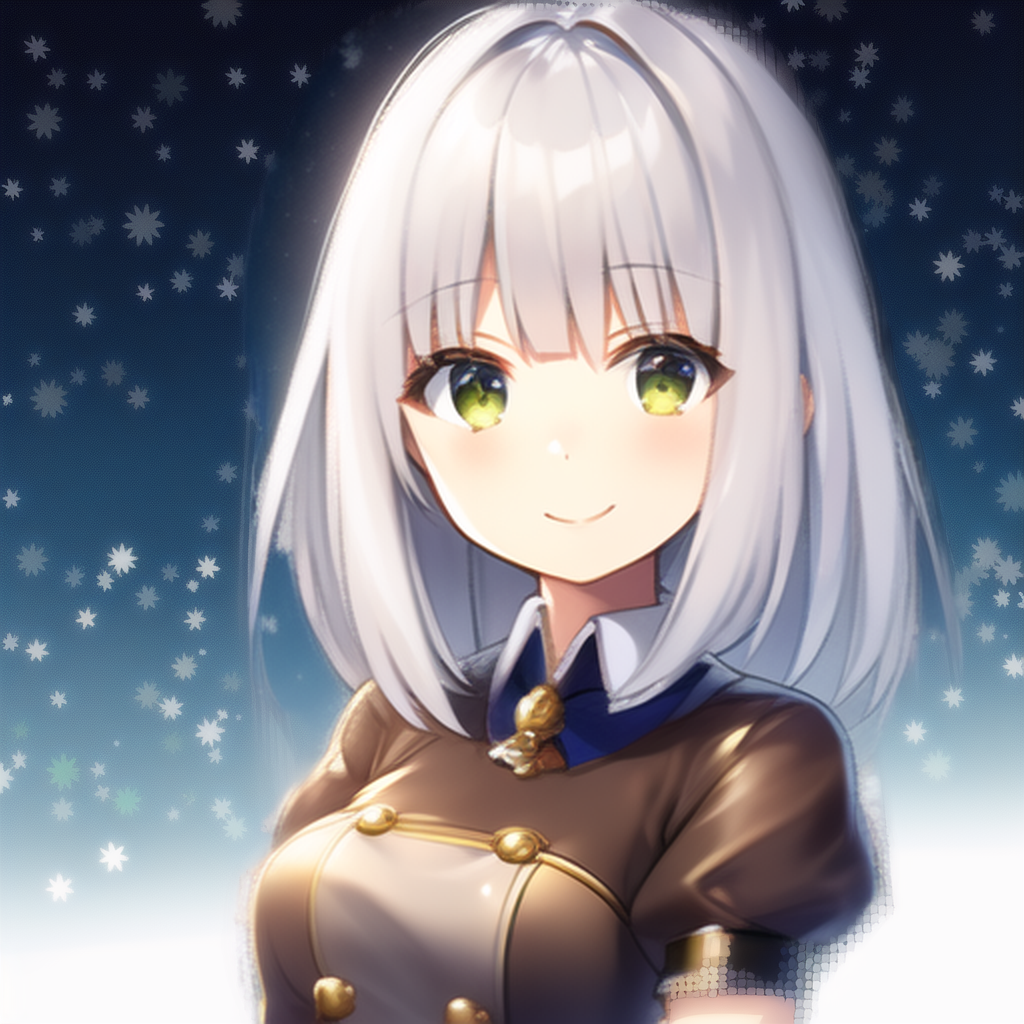

Finish image generation!
The prompt is <t2i>
1girl,cute smile,medium and silver hair,bangs,<lora:dreamwave:0.6>,
Negative prompt: longbody,lowres,bad anatomy,bad hands,missing fingers,pubic hair,extra digit,fewer digits,cropped,worst quality,low quality,
Steps: 20, Sampler: Euler a, CFG scale: 7, Seed: 3687350510, Size: 512x512, Model hash: 7f96a1a9ca, Model: anything-v5-PrtRE, Denoising strength: 0.4, Clip skip: 2, ADetailer model: face_yolov8n.pt, ADetailer confidence: 0.3, ADetailer dilate erode: 4, ADetailer mask blur: 4, ADetailer denoising strength: 0.4, ADetailer inpaint only masked: True, ADetailer inpaint padding: 32, ADetailer model 2nd: hand_yolov8n.pt, ADetailer confidence 2nd: 0.3, ADetailer dilate erode 2nd: 4, ADetailer mask blur 2nd: 4, ADetailer denoising strength 2nd: 0.4, ADetailer inpaint only masked 2nd: True, ADetailer inpaint padding 2nd: 32, ADetailer model 3rd: person_yolov8n-seg.pt, ADetailer confidence 3rd: 0.3, ADetailer dilate erode 3rd: 4, ADetailer mask b

{'input': '<t2i>\n1girl,cute smile,medium and silver hair,bangs,<lora:dreamwave:0.6>,\nNegative prompt: longbody,lowres,bad anatomy,bad hands,missing fingers,pubic hair,extra digit,fewer digits,cropped,worst quality,low quality,\nSteps: 20, Sampler: Euler a, CFG scale: 7, Seed: 3687350510, Size: 512x512, Model hash: 7f96a1a9ca, Model: anything-v5-PrtRE, Denoising strength: 0.4, Clip skip: 2, ADetailer model: face_yolov8n.pt, ADetailer confidence: 0.3, ADetailer dilate erode: 4, ADetailer mask blur: 4, ADetailer denoising strength: 0.4, ADetailer inpaint only masked: True, ADetailer inpaint padding: 32, ADetailer model 2nd: hand_yolov8n.pt, ADetailer confidence 2nd: 0.3, ADetailer dilate erode 2nd: 4, ADetailer mask blur 2nd: 4, ADetailer denoising strength 2nd: 0.4, ADetailer inpaint only masked 2nd: True, ADetailer inpaint padding 2nd: 32, ADetailer model 3rd: person_yolov8n-seg.pt, ADetailer confidence 3rd: 0.3, ADetailer dilate erode 3rd: 4, ADetailer mask blur 3rd: 4, ADetailer den

In [16]:
agent_exec.invoke(input)